In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_gaussian_quantiles
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#!pip install xgboost
import xgboost as xgb

In [ ]:
def make_toy_dataset(n= 100, random_seed = None):
    """ Generate a toy dataset for evaluating AdaBoost classifiers """
    
    n_per_class = int(n/2)
    
    if random_seed:
        np.random.seed(random_seed)

    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    
    return X, y*2-1

def plot_decision_boundary(classifier, X, y, N = 10,scatter_weights = np.ones(len(y)),ax = None):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    
    #Check what methods are available
    zz = classifier.predict(np.c_[xx.ravel(), yy.ravel()])            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

def AdaBoost_scratch(X,y, M=10, learning_rate = 0.5):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [],[],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

In [5]:
X, y = make_toy_dataset(n=20, random_seed=10)


Train error: 0.0%


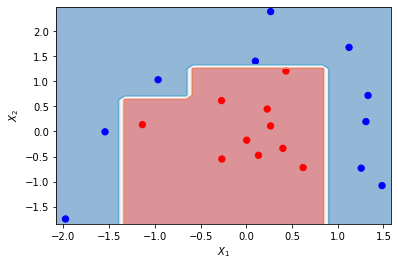

In [10]:
from sklearn.ensemble import AdaBoostClassifier

bench = AdaBoostClassifier(n_estimators=10, algorithm='SAMME').fit(X, y)
plot_decision_boundary(bench,X,y,50)

train_err = (bench.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')

In [11]:
def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

### Running scratch AdaBoost
Accuracy = 100% - same as for Sklearn implementation

In [12]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=10)

Accuracy =  1.0


Accuracy =  1.0


F:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: UserWarning: No contour levels were found within the data range.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: UserWarning: No contour levels were found within the data range.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: UserWarning: No contour levels were found within the data range.


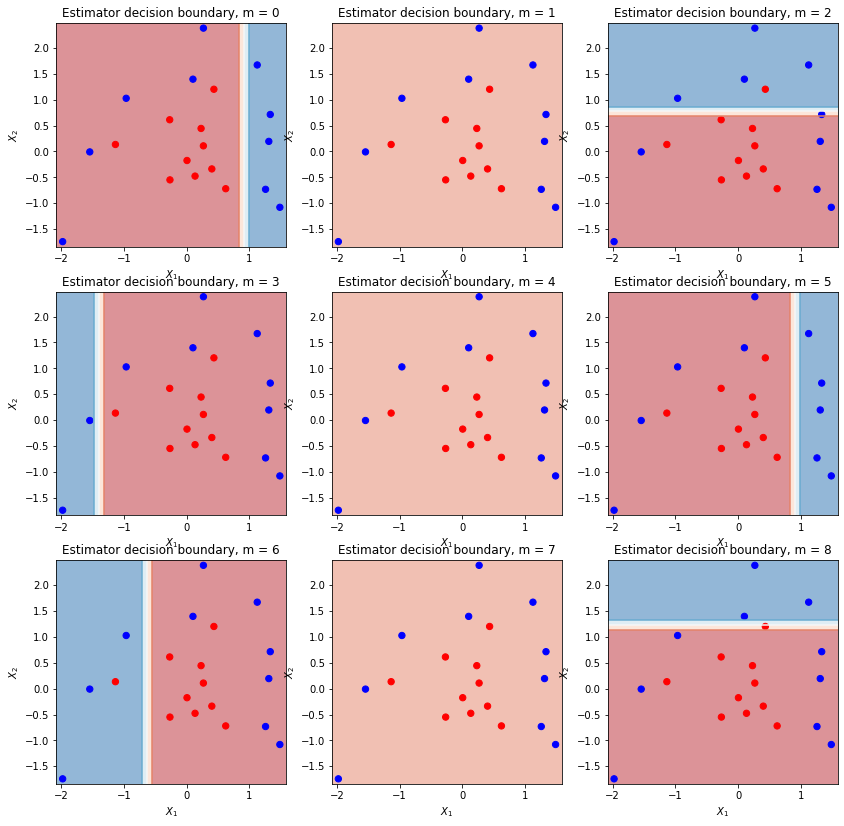

In [14]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=10, learning_rate = 1)

fig = plt.figure(figsize = (14,14))
for m in range(0,9):
    fig.add_subplot(3,3,m+1)
    s_weights = (sample_weight_list[m,:] / sample_weight_list[m,:].sum() ) * 40
    #print(estimator_list[m].predict(X))
    plot_decision_boundary(estimator_list[m], X,y,N = 20, scatter_weights =s_weights )
    plt.title('Estimator decision boundary, m = {}'.format(m))

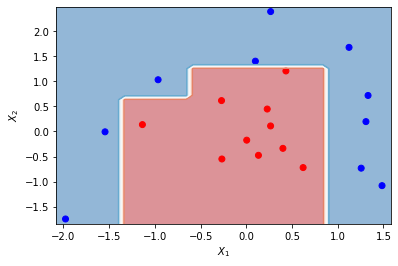

In [15]:
def plot_AdaBoost_scratch_boundary(estimators,estimator_weights, X, y, N = 10,ax = None ):
    
    def AdaBoost_scratch_classify(x_temp, est,est_weights ):
        '''Return classification prediction for a given point X and a previously fitted AdaBoost'''
        temp_pred = np.asarray( [ (e.predict(x_temp)).T* w for e, w in zip(est,est_weights )]  ) / est_weights.sum()
        return np.sign(temp_pred.sum(axis = 0))
    
    
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))


    zz = np.array( [AdaBoost_scratch_classify(np.array([xi,yi]).reshape(1,-1), estimators,estimator_weights ) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )


### The decision boundary from scratch code is the same as Sklearn built in model.

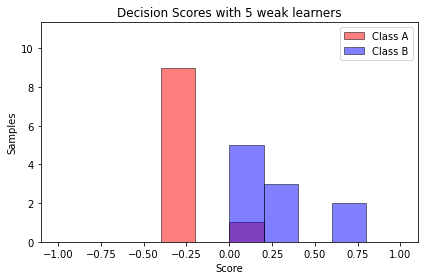

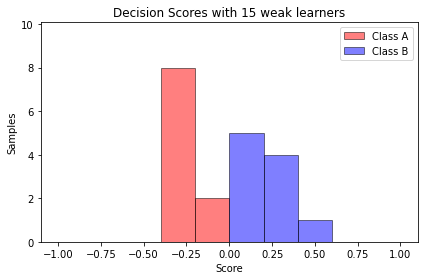

In [16]:
bench = AdaBoostClassifier(n_estimators=5, algorithm='SAMME').fit(X, y)
twoclass_output = bench.decision_function(X)
plot_range = (-1, 1)
class_names = "AB"

for i, n, c in zip(range(2), class_names, "rb"):
    plt.hist(
        twoclass_output[y == (2*i-1)],
        bins=10,
        range=plot_range,
        facecolor=c,
        label="Class %s" % n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel("Score")
plt.title("Decision Scores with 5 weak learners")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()



####
bench = AdaBoostClassifier(n_estimators=15, algorithm='SAMME').fit(X, y)
twoclass_output = bench.decision_function(X)
class_names = "AB"

for i, n, c in zip(range(2), class_names, "rb"):
    plt.hist(
        twoclass_output[y == (2*i-1)],
        bins=10,
        range=plot_range,
        facecolor=c,
        label="Class %s" % n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel("Score")
plt.title("Decision Scores with 15 weak learners")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [17]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.Categorical.from_codes(breast_cancer.target, breast_cancer.target_names)

In [18]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [19]:
print(y)

['malignant', 'malignant', 'malignant', 'malignant', 'malignant', ..., 'malignant', 'malignant', 'malignant', 'malignant', 'benign']
Length: 569
Categories (2, object): ['malignant', 'benign']


In [20]:
encoder = LabelEncoder()
binary_encoded_y = pd.Series(encoder.fit_transform(y))
train_X, test_X, train_y, test_y = train_test_split(X, binary_encoded_y, random_state=1)

In [21]:
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)
classifier.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

In [22]:
predictions = classifier.predict(test_X)
confusion_matrix(test_y, predictions)

array([[86,  2],
       [ 3, 52]], dtype=int64)

     |████████████████████████████████| 1.3 MB 274 kB/s eta 0:00:01
